# Tutorial Warn module

This tutorial shows how to use the `Warn` module to generate a warning, i.e., 2D map of coordinates
with assigned warn levels. Operations, their order, and their influence (operations sizes, gradual decrease of warn levels, and changing of too small regions to surrounding) can be selected to generate the warning.
The functionality of the `Warn` module of reducing heterogeneity in a map can be applied to
different
inputs,
e.g., MeteoSwiss windstorm data (COSMO data), `TC`s, `Impact`s, etc. The Warn module can also be
used
to cluster data visualized on a map.
The master's thesis corresponding to this module (more information about operations) can be found
here: 10.3929/ethz-b-000548850

In [2]:
import numpy as np
import xarray as xr

from climada_petals.engine.warn import Warn, Operation
from climada.util.plot import geo_bin_from_array
from climada.entity import ImpfTropCyclone, ImpactFuncSet
from climada.util.api_client import Client


plotting_parameters = dict()
plotting_parameters['cmap'] = 'Wistia'

# MeteoSwiss Storm Example

The first example is to generate a warn map of numerical weather predictions, in this case a wind storm prognose computed by MeteoSwiss.

In [3]:
# Load MeteoSwiss storm example via client (COSMO2-E model)
client = Client()
dataset = client.get_dataset_info(name="cosmo2_2019121400")
path_files = client.download_dataset(dataset)[1][0]
ncdf = xr.open_dataset(path_files)
wind_matrix = ncdf.VMAX_10M.values[0, :, :]  # take one ensemble member of the numerical weather model COSMO

lon = ncdf.lon_1.values
lat = ncdf.lat_1.values
coord = np.vstack((lat.flatten(), lon.flatten())).transpose()

To show the raw data first, no operations are applied. This shows then the binned data only.

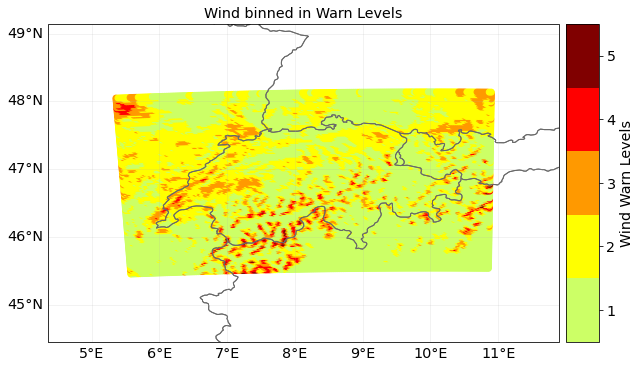

In [5]:
# Define warn levels for this example
warn_levels = np.array([0.0, 19.44, 25.0, 30.55, 38.88, 300.0])

# Define warning parameters, such that the data is only binned in warn levels (without operations)
warn_params_only_binning = Warn.WarnParameters(warn_levels, operations=[])
binned_map = Warn.from_map(wind_matrix, coord, warn_params_only_binning)
binned_map.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Wind binned in Warn Levels');

## Demonstrate Warning Generation

The first example shows a default selection of operations and their properties.

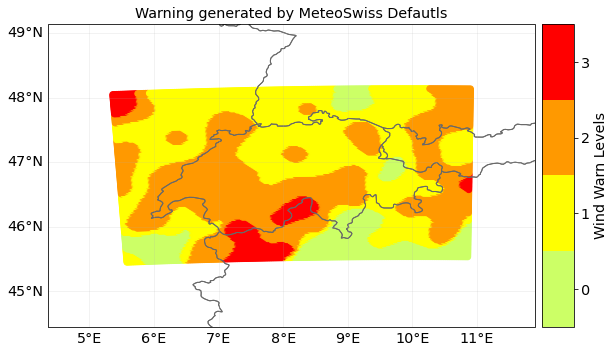

In [4]:
# Define warning parameters, such that the data is generated with default parameters
warn_params_default = Warn.WarnParameters(warn_levels)
default_op_warning = Warn.from_map(wind_matrix, coord, warn_params_default)
default_op_warning.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning generated by '
                                                                    'MeteoSwiss Defaults');

When generating a warning, operations and their sizes can be selected by the users. This has an impact on what the warning looks like. The different operations and a possible combination of them can be seen below.

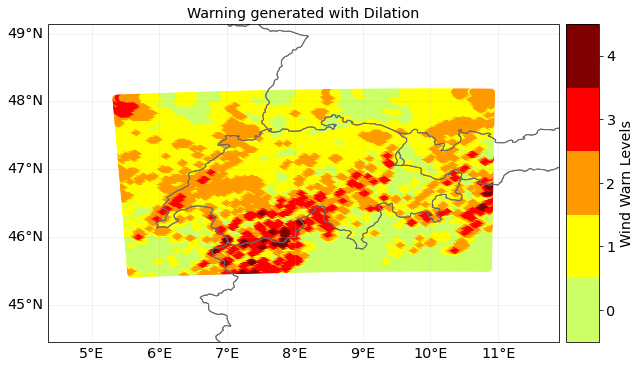

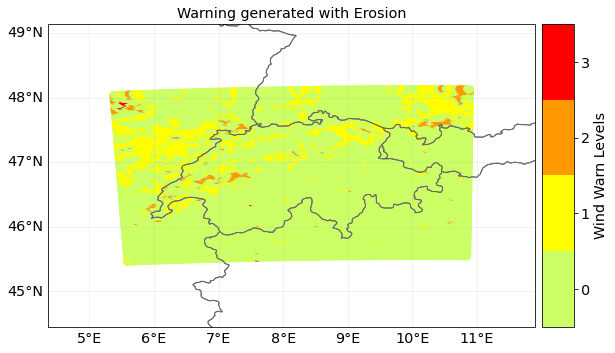

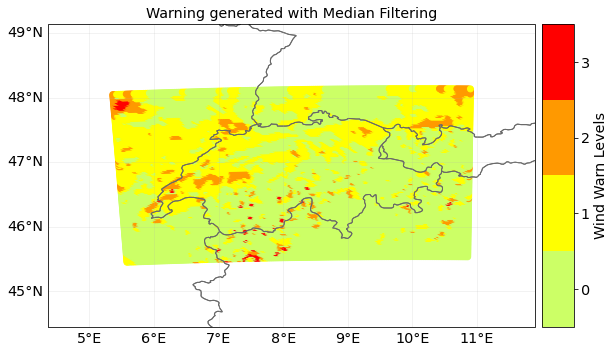

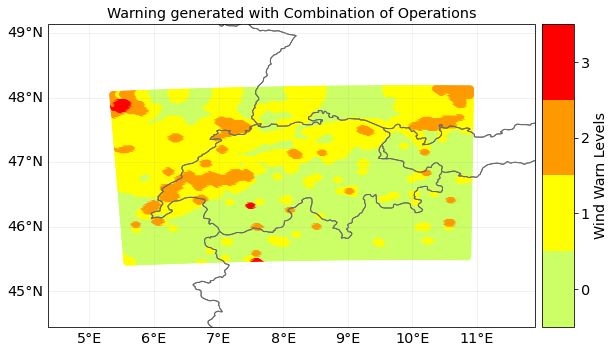

In [5]:
# only dilation - expands areas in warn levels above 0
warn_params = Warn.WarnParameters(warn_levels, operations=[(Operation.dilation, 2)])
warn_dilation_only = Warn.from_map(wind_matrix, coord, warn_params)
warn_dilation_only.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning generated with '
                                                                    'Dilation');
# only erosion - reduces areas in warn levels above 0 and heterogeneity
warn_params = Warn.WarnParameters(warn_levels, operations=[(Operation.erosion, 1)])
warn_erosion_only = Warn.from_map(wind_matrix, coord, warn_params)
warn_erosion_only.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning generated with '
                                                                   'Erosion');
# only median filtering - smooths out all areas (best applied after forming regions)
warn_params = Warn.WarnParameters(warn_levels, operations=[(Operation.median_filtering, 3)])
warn_median_only = Warn.from_map(wind_matrix, coord, warn_params)
warn_median_only.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning generated with Median '
                                                                  'Filtering');
# first ersoion, then dilation, then median filtering
warn_params = Warn.WarnParameters(warn_levels, operations=[(Operation.erosion, 1),
                                                           (Operation.dilation, 3),
                                                           (Operation.median_filtering, 3)])
warn_combination = Warn.from_map(wind_matrix, coord, warn_params)
warn_combination.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning generated with '
                                                                  'Combination of Operations');

Next to selecting the operations, one can select whether the highest warn levels should be gradually decreased by its
neighboring regions (if True) to the lowest level (e.g., level 3, 2, 1, 0) or larger steps are allowed
(e.g., from level 5 directly to 2). Since this parameter doesn't have a large influence here, study also the next example.

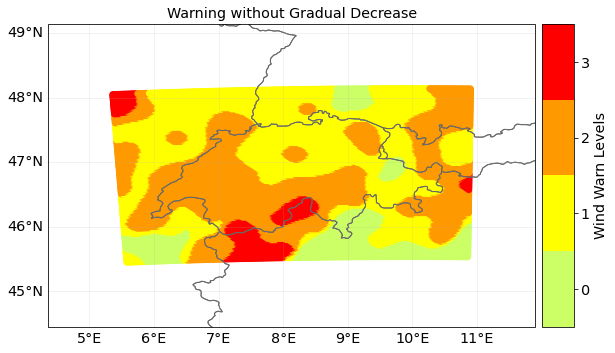

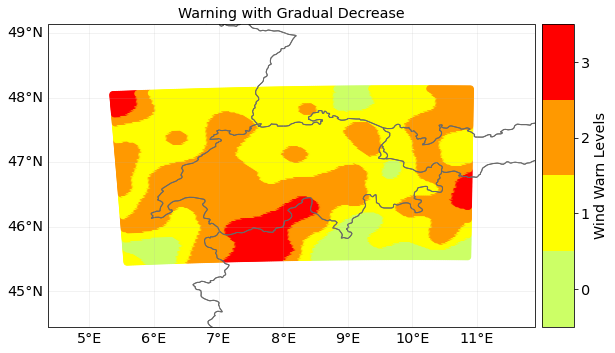

In [6]:
# Warning without and with gradual decrease of regions of higher level to lower levels to see difference to default parameters plot
warn_params = Warn.WarnParameters(warn_levels)
warn_wo_grad = Warn.from_map(wind_matrix, coord, warn_params)
warn_wo_grad.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning without Gradual Decrease');

warn_params = Warn.WarnParameters(warn_levels, gradual_decr=True)
warn_wo_grad = Warn.from_map(wind_matrix, coord, warn_params)
warn_wo_grad.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning with Gradual Decrease');

Further, small regions of a warn level formed by the algorithm can be changed to the surrounding warn level.
Therefore, the parameter `change_sm` needs to be set to the number of coordinate below which a region is regarded as to small.

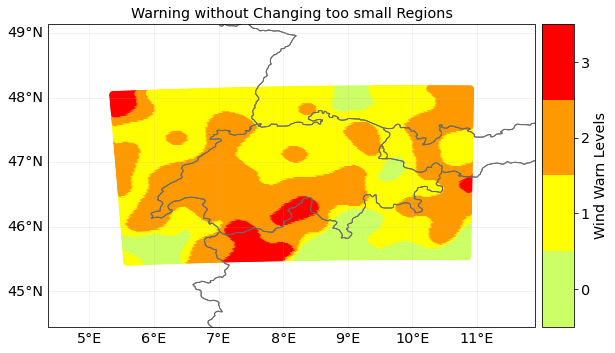

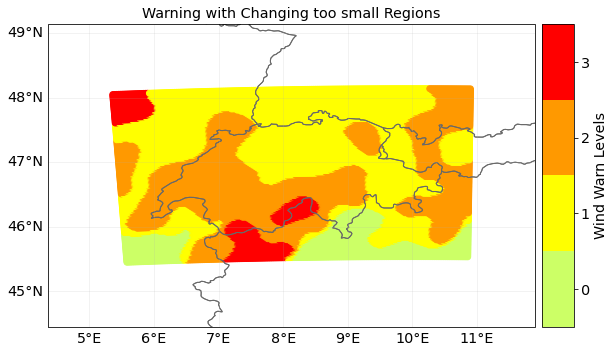

In [7]:
# Warning without and with change too small regions by setting levels newly.
warn_params = Warn.WarnParameters(warn_levels)
warn_not_changed = Warn.from_map(wind_matrix, coord, warn_params)
warn_not_changed.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning without Changing too '
                                                                  'small Regions');

warn_params = Warn.WarnParameters(warn_levels, change_sm=350)
warn_changed = Warn.from_map(wind_matrix, coord, warn_params)
warn_changed.plot_warning_meteoswiss_style(var_name='Wind Warn Levels', title='Warning with Changing too small '
                                                              'Regions');

# Hazard Example - TC Haiti

This example shows how the Warn module can be used to generate warnings of natural catastrophes, e
.g., tropical cyclons.

In [8]:
tc_dataset_infos = client.list_dataset_infos(data_type='tropical_cyclone')
client.get_property_values(tc_dataset_infos, known_property_values = {'country_name':'Haiti'});

2022-05-16 17:34:41,027 - climada.hazard.base - INFO - Reading /Users/robertblass/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040/v1/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040.hdf5


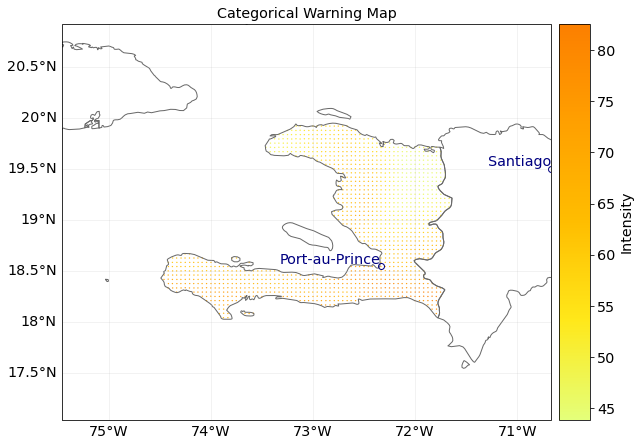

In [9]:
# Read hazard
tc_haiti = client.get_hazard('tropical_cyclone', properties={'country_name': 'Haiti', 'climate_scenario': 'rcp45', 'ref_year':'2040', 'nb_synth_tracks':'10'})
tc_haiti.intensity = tc_haiti.intensity.max(axis=0)

lon = tc_haiti.centroids.lon
lat = tc_haiti.centroids.lat
coord_haiti = np.vstack((lat.flatten(), lon.flatten())).transpose()

geo_bin_from_array(tc_haiti.intensity.todense().transpose(), coord_haiti, 'Intensity', 'Categorical Warning Map', **plotting_parameters);

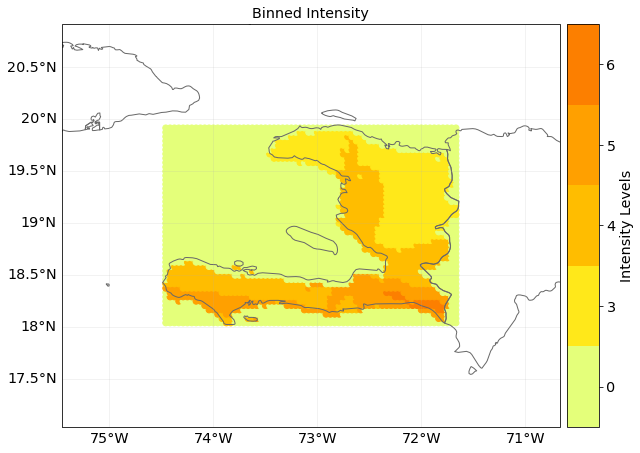

In [10]:
# Plot binned intensities
# warn Levels
warn_levels = [0, 20, 30, 40, 60, 70, 80, 1000]
grid, coord_haiti = Warn.zeropadding(tc_haiti.centroids.lat, tc_haiti.centroids.lon, tc_haiti
                                 .intensity.todense())

# no filtering operations applied - only binning as reference
warn_params_only_binning = Warn.WarnParameters(warn_levels, operations=[])
binned_only = Warn.from_map(grid, coord_haiti, warn_params_only_binning)
binned_only.plot_warning(var_name='Intensity Levels', title='Binned Intensity', **plotting_parameters);

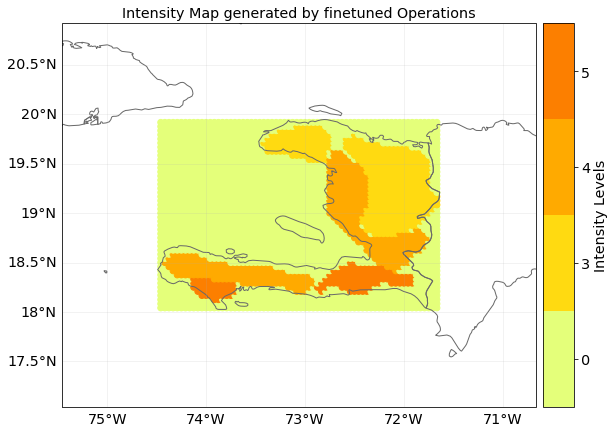

In [11]:
# Apply fine tuned filtering operations
warn_params = Warn.WarnParameters(warn_levels, operations=[(Operation.erosion, 1),
                                                           (Operation.dilation, 1),
                                                           (Operation.median_filtering, 5)])
warn_def = Warn.from_map(grid, coord_haiti, warn_params)
warn_def.plot_warning(var_name='Intensity Levels', title='Intensity Map generated by finetuned Operations', **plotting_parameters);

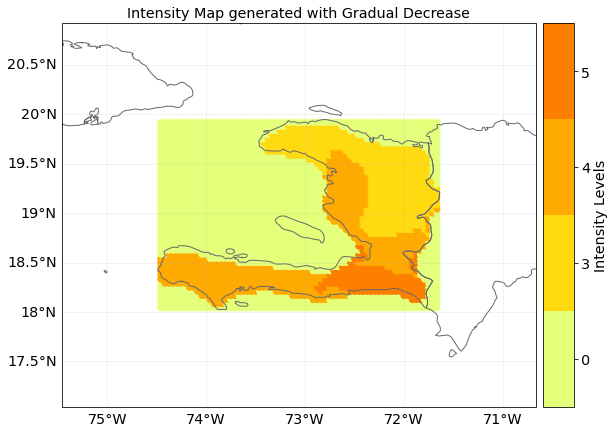

In [12]:
# Apply same operations with gradual decrease and changing too small regions to surrounding
warn_params = Warn.WarnParameters(warn_levels, operations=[(Operation.erosion, 1),
                                                           (Operation.dilation, 1),
                                                           (Operation.median_filtering, 5)],
                                  gradual_decr=True,
                                  change_sm=100)
warn_def = Warn.from_map(grid, coord_haiti, warn_params)
warn_def.plot_warning(var_name='Intensity Levels', title='Intensity Map generated with Gradual Decrease', **plotting_parameters);

# Impact Example - Value (USD) Haiti

This example shows how the Warn module can be used on any 2D map of values (here impact cost in
USD).
It can cluster and smooth the given data map.

In [13]:
# Get data
exp_haiti = client.get_litpop_default(country="Haiti");

2022-05-16 17:34:49,880 - climada.entity.exposures.base - INFO - Reading /Users/robertblass/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v1/LitPop_150arcsec_HTI.hdf5


In [14]:
impf = ImpfTropCyclone().from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf)

/Users/robertblass/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


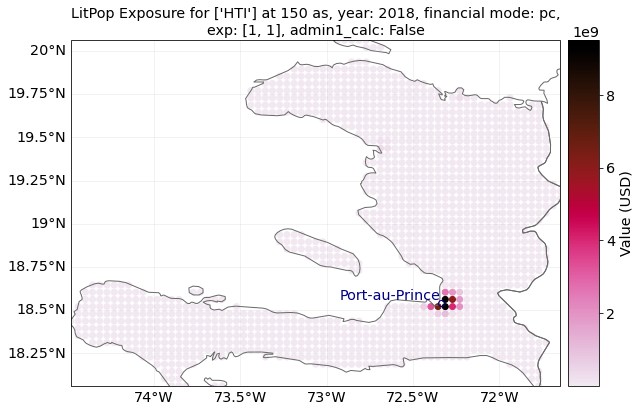

In [15]:
# Plot exposures
exp_haiti.plot_scatter();

In [16]:
# Project values to rectangle
lat, lon, values = exp_haiti.gdf.latitude.to_numpy(), exp_haiti.gdf.longitude.to_numpy(), exp_haiti.gdf.value.to_numpy()
grid, coord_impf = Warn.zeropadding(lat, lon, values)

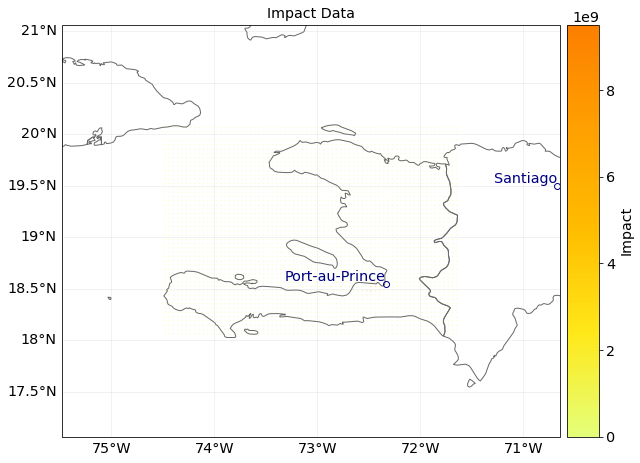

In [17]:
# Plot raw data
geo_bin_from_array(grid.flatten(), coord_impf, 'Impact', 'Impact Data', **plotting_parameters);

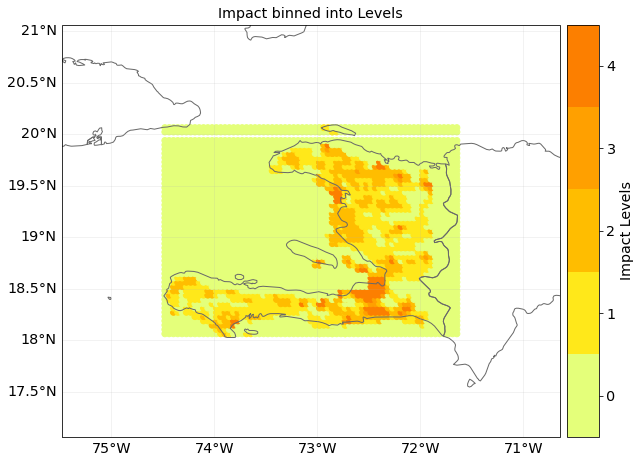

In [18]:
# Bin data into levels and plot binned data
levels = [0, 500000, 1000000, 6000000, 10000000, 10000000000]
warn_params = Warn.WarnParameters(levels, operations=[])
warn_def = Warn.from_map(grid, coord_impf, warn_params)
warn_def.plot_warning(var_name='Impact Levels', title='Impact binned into Levels', **plotting_parameters);

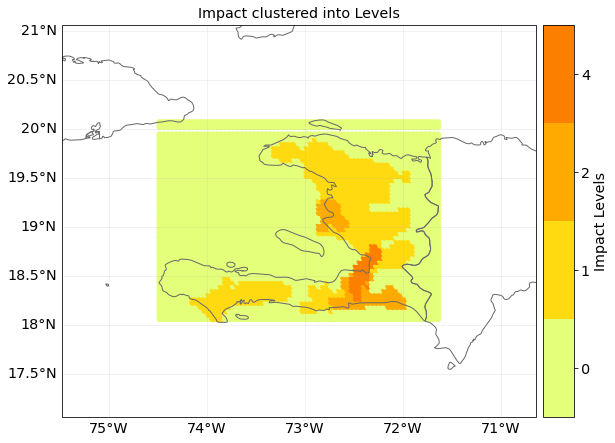

In [19]:
# Apply fine tuned filtering operations with gradual decrease and changing too small regions
warn_levels = [0, 500000, 1000000, 6000000, 10000000,   10000000000]
warn_params = Warn.WarnParameters(warn_levels, operations=[(Operation.erosion, 1), (Operation.dilation,
                                                                                    1),
                                                           (Operation.median_filtering, 3)], gradual_decr=True,
                                  change_sm=50)
warn_def = Warn.from_map(grid, coord_impf, warn_params)
warn_def.plot_warning(var_name='Impact Levels', title='Impact clustered into Levels', **plotting_parameters);